In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import squidpy as sq
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from anndata import AnnData
import scipy.sparse as sp

# Load the data
sample_id = "IMMUNEX001"
adata = sc.read_10x_h5(f"/scratch/IMMUNEX/OUTPUT/Visium_NSCLC_{sample_id}/outs/binned_outputs/square_002um/filtered_feature_bc_matrix.h5")
adata.raw = adata
adata.uns['sample_id'] = sample_id
adata

KeyboardInterrupt: 

In [ ]:
import pandas as pd

# Load coordinates from Space Ranger output (adjust path as needed)
parquet_path = f"/scratch/IMMUNEX/OUTPUT/Visium_NSCLC_{sample_id}/outs/binned_outputs/square_002um/spatial/tissue_positions.parquet"
coords = pd.read_parquet(parquet_path)
display(coords.head())

# Set barcode index if not done
coords.set_index("barcode", inplace=True)

# Join without suffix — no conflict now
adata.obs = adata.obs.join(coords, how="left")
display(adata.obs)

# Keep only bins with spatial coordinates
adata = adata[adata.obs["pxl_row_in_fullres"].notnull()].copy()

# Add to obsm
adata.obsm["spatial"] = adata.obs[["pxl_row_in_fullres", "pxl_col_in_fullres"]].values

adata.obs["library_id"] = "IMMUNEX001"
adata.uns["spatial"] = {
    "IMMUNEX001": {
        "images": {"hires": None},
        "scalefactors": {
            "tissue_hires_scalef": 1.0,
            "spot_diameter_fullres": 1.0
        }
    }
}


In [ ]:
adata.obs['TLS'] = None

tls_annotation = pd.read_csv('/scratch/IMMUNEX/data/TLS_ANNOTATIONS/TLSIMMUNEX001.csv')
tls_annotation.columns = ['barcode_8um','TLS']
tls_annotation[['row_8', 'col_8']] = tls_annotation['barcode_8um'].str.extract(r's_008um_(\d+)_(\d+)', expand=True).astype(int)

display(tls_annotation.head())

import pandas as pd
import numpy as np

# Initialize TLS column in 2µm bins
adata.obs['TLS'] = 0

# Extract row/col from 8µm barcodes
tls_annotation[['row_8', 'col_8']] = tls_annotation['barcode_8um'].str.extract(r's_008um_(\d+)_(\d+)', expand=True).astype(int)

# Loop over TLS rows where TLS is not NaN (i.e., presence)
for _, row in tqdm(tls_annotation[tls_annotation['TLS'].notna()].iterrows(), total=tls_annotation['TLS'].notna().sum(), desc="Mapping TLS to 2µm bins"):
    row_2_start = row['row_8'] * 4
    row_2_end = row_2_start + 3
    col_2_start = row['col_8'] * 4
    col_2_end = col_2_start + 3

    # Find matching 2µm bins
    match = (
        (adata.obs['array_row'] >= row_2_start) & (adata.obs['array_row'] <= row_2_end) &
        (adata.obs['array_col'] >= col_2_start) & (adata.obs['array_col'] <= col_2_end)
    )

    # Set TLS = 1 for matched bins
    adata.obs.loc[match, 'TLS'] = 1


In [ ]:
adata.obs["library_id"] = "IMMUNEX001"
adata.uns["spatial"] = {
    "VisiumHD_dummy": {
        "images": {"hires": None},
        "scalefactors": {
            "tissue_hires_scalef": 1.0,
            "spot_diameter_fullres": 1.0
        }
    }
}


/tmp/ipykernel_3138674/2306363759.py:24: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


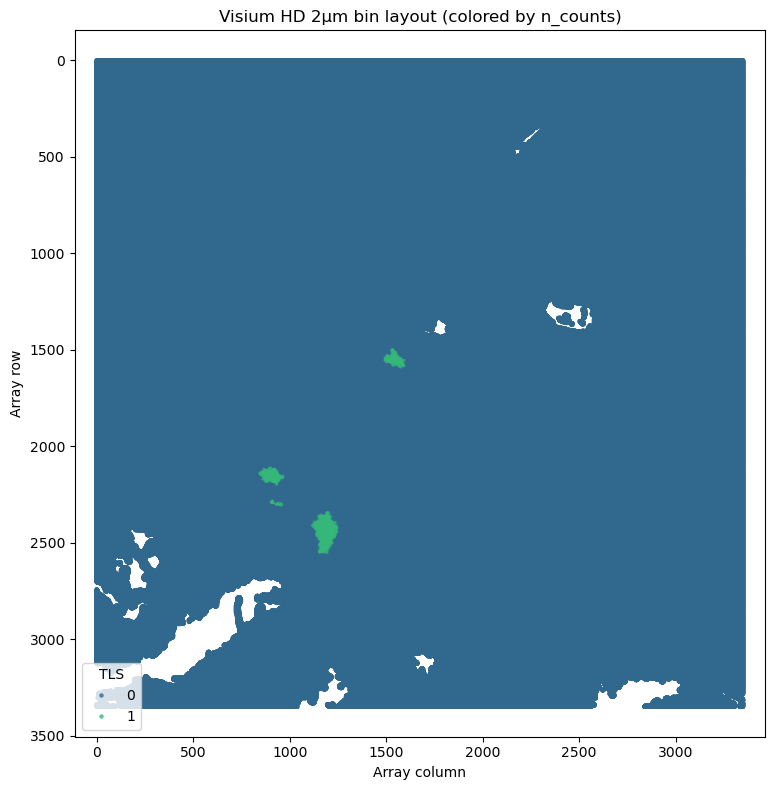

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data
df = adata.obs.reset_index()

plt.figure(figsize=(8, 8))
sns.scatterplot(
    data=df,
    x="array_col",
    y="array_row",
    hue="TLS",
    palette="viridis",
    s=10,
    linewidth=0,
    alpha=0.8
)

plt.gca().invert_yaxis()
plt.axis("equal")
plt.title("Visium HD 2µm bin layout (colored by n_counts)")
plt.xlabel("Array column")
plt.ylabel("Array row")
plt.tight_layout()
plt.show()


In [53]:
# Mitochondrial genes
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)


In [ ]:
# # Plot QC
# sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')

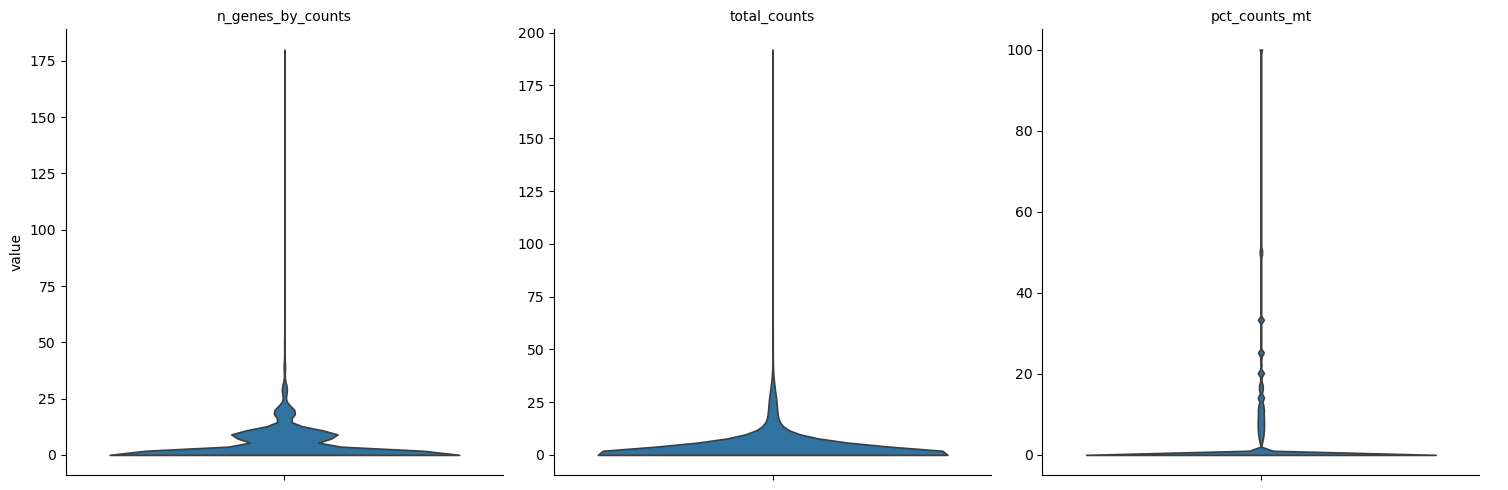

In [54]:
adata.var_names_make_unique()
adata.raw = adata.copy()
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=1, multi_panel=True, stripplot=False )


In [ ]:
# sc.pl.spatial(
#     adata,
#     color=["TLS", "total_counts", "pct_counts_mt"],
#     size=0.1,
#     cmap="viridis",  # or specify list of colormaps for each
#     ncols=3,         # number of panels per row
#     show=True
# )


In [55]:
# Filter out extremely low-count bins, but keep most signal
sc.pp.filter_cells(adata, min_counts=10)
sc.pp.filter_genes(adata, min_cells=5)
adata

AnnData object with n_obs × n_vars = 2360586 × 17907
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'library_id', 'TLS', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'sample_id', 'spatial'
    obsm: 'spatial'

In [56]:
# Normalize and log1p
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# # Plot total counts after normalization
# sc.pl.highest_expr_genes(adata, n_top=20)

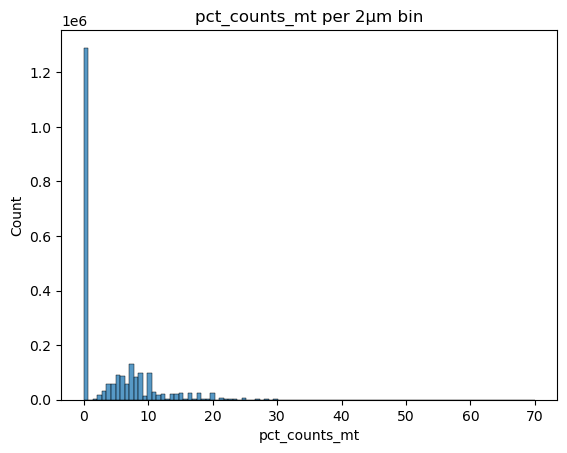

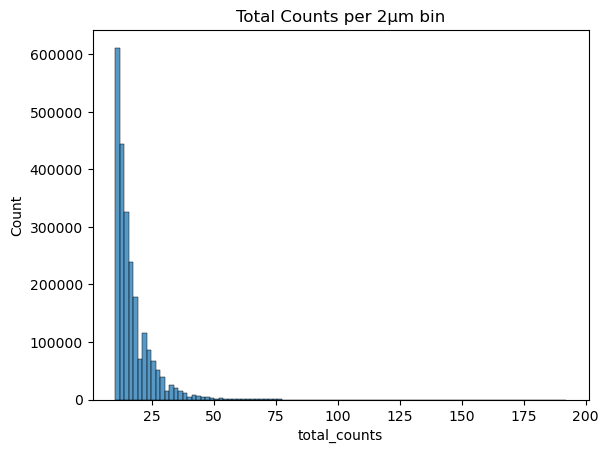

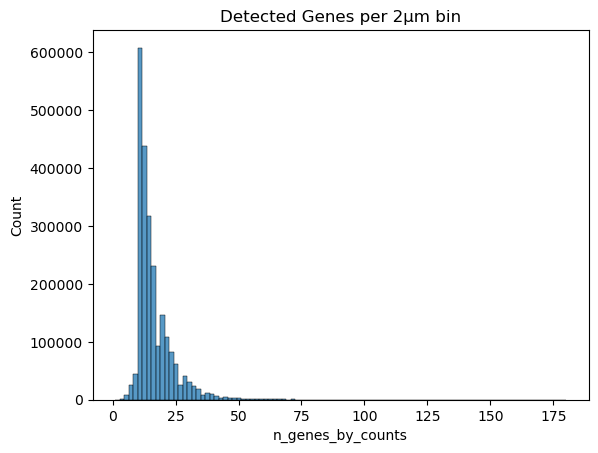

In [57]:

sns.histplot(adata.obs['pct_counts_mt'], bins=100)
plt.title("pct_counts_mt per 2µm bin")
plt.show()

sns.histplot(adata.obs['total_counts'], bins=100)
plt.title("Total Counts per 2µm bin")
plt.show()

sns.histplot(adata.obs['n_genes_by_counts'], bins=100)
plt.title("Detected Genes per 2µm bin")
plt.show()


In [61]:
adata

AnnData object with n_obs × n_vars = 2360586 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'library_id', 'TLS', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'sample_id', 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

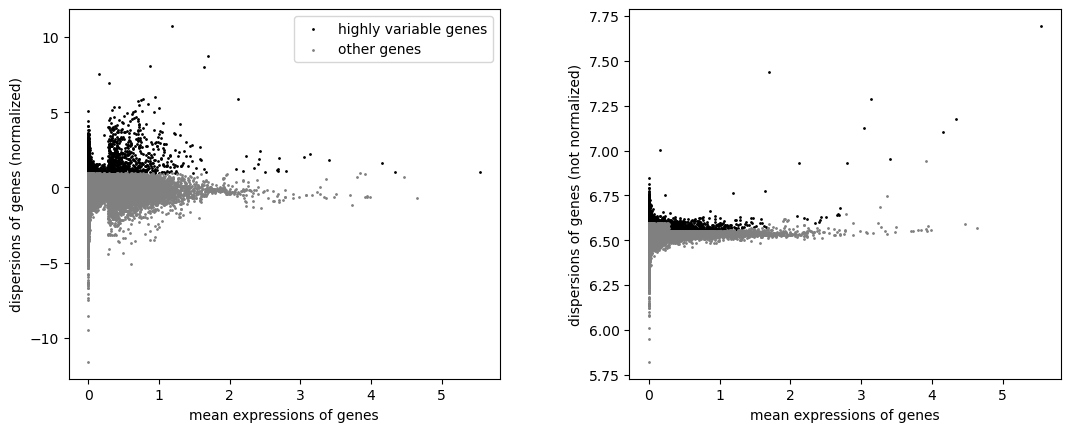

/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


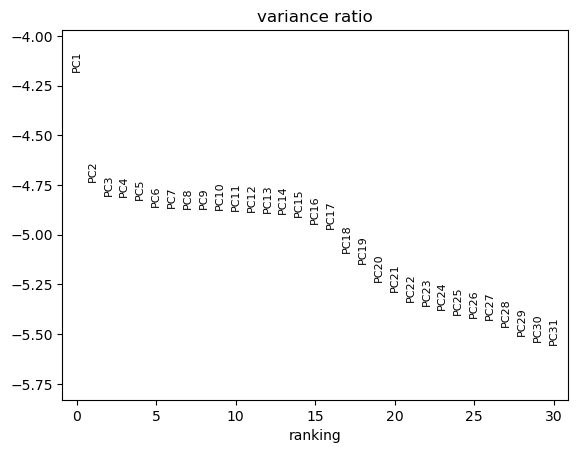

In [58]:
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)
sc.pl.highly_variable_genes(adata)

adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.pl.pca_variance_ratio(adata, log=True)



In [60]:
# Neighbors and clustering
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=15, n_jobs=50)

,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres,library_id,TLS,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,n_counts
s_002um_02587_02503-1,1,2587,2503,66022.627347,63950.896847,IMMUNEX001,0,16,2.833213,16.0,2.833213,100.0,100.0,100.0,100.0,0.0,0.000000,0.0,16.0
s_002um_01751_01251-1,1,1751,1251,58610.929837,74832.262299,IMMUNEX001,0,29,3.401197,30.0,3.433987,100.0,100.0,100.0,100.0,0.0,0.000000,0.0,30.0
s_002um_02457_01347-1,1,2457,1347,64792.708123,74049.510467,IMMUNEX001,0,12,2.564949,12.0,2.564949,100.0,100.0,100.0,100.0,0.0,0.000000,0.0,12.0
s_002um_02623_02399-1,1,2623,2399,66329.079103,64863.247106,IMMUNEX001,0,16,2.833213,16.0,2.833213,100.0,100.0,100.0,100.0,2.0,1.098612,12.5,16.0
s_002um_01754_00936-1,1,1754,936,58611.790185,77587.161114,IMMUNEX001,0,10,2.397895,10.0,2.397895,100.0,100.0,100.0,100.0,0.0,0.000000,0.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_002um_01961_00332-1,1,1961,332,60373.381549,82885.802041,IMMUNEX001,0,10,2.397895,12.0,2.564949,100.0,100.0,100.0,100.0,0.0,0.000000,0.0,12.0
s_002um_01778_00775-1,1,1778,775,58808.703456,78997.033135,IMMUNEX001,0,11,2.484907,11.0,2.484907,100.0,100.0,100.0,100.0,0.0,0.000000,0.0,11.0
s_002um_02440_02775-1,1,2440,2775,64758.999618,61560.514823,IMMUNEX001,0,9,2.302585,10.0,2.397895,100.0,100.0,100.0,100.0,0.0,0.000000,0.0,10.0
s_002um_01498_01467-1,1,1498,1467,56415.832825,72923.024157,IMMUNEX001,0,15,2.772589,15.0,2.772589,100.0,100.0,100.0,100.0,0.0,0.000000,0.0,15.0


In [ ]:
sc.tl.leiden(adata, resolution=0.5)

In [ ]:
sc.tl.umap(adata, min_dist=0.5, spread=1.0, random_state=42)

In [ ]:

# Visualize clustering
sc.pl.umap(adata, color=["leiden"], title="Leiden clusters")

In [ ]:
# # Show spatial clustering
# sq.pl.spatial_scatter(adata, color="leiden", size=1.0, title="Leiden clusters (spatial)")


In [ ]:
# Build spatial neighbors graph
sq.gr.spatial_neighbors(adata, coord_type="grid")


In [ ]:

# Spatial autocorrelation (Moran’s I)
sq.gr.spatial_autocorr(adata, mode="moran")
sq.pl.spatial_autocorr(adata, mode="moran", genes=adata.var.highly_variable[:6].tolist())
